**Recurrent Neural Networks with Long Short Term Memory Units for Time Series Predictions and Imputations Test - 17 Nov**



1. Test on all Monday 24 hours data for State Eb L_2

In [1]:
!pip install tf-nightly-2.0-preview

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import os
import math
print(tf.__version__)

2.0.0-dev20191002


In [3]:
dataset = pd.read_csv('allmonday_reviseddata_modified.csv', header=0, index_col=None)

#replace missing values y -10 to test if model will learn to not include these in these as missing values
dataset_w_missing = dataset.fillna(-10,inplace=True)
dataset = dataset[:-240]
#check
print (dataset.iloc[49]['State-EB-L_2'])
print (dataset.iloc[3359]['State-EB-L_2'])

-10.0
5.0


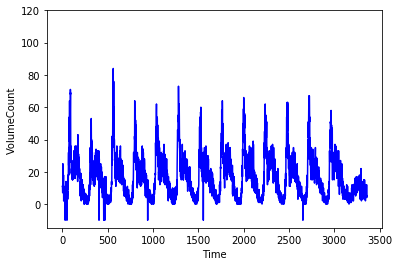

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("VolumeCount")
    plt.grid(False)

#extract State-EB-L_2 series 
series = dataset['State-EB-L_2'].values
time = dataset['date_time'].values

time_num = [i for i in range(len(series))]
plt.plot(time_num, series, color = 'blue')
#plot_series(time_num, series)

plt.xlabel("Time")
plt.ylabel("VolumeCount")
plt.ylim(top=120)
plt.grid(False)

**Split data into training and time**

**Define window_size, batch_size, and shuffle_buffer_size for modelling**

Window Size

batch Size

Shuffle uffer Size

In [5]:
num_days = 11
split_time = num_days*240
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 80
batch_size = 30
shuffle_buffer_size = 100

**Creating windowed dataset**

Give explanation...



In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
dataset = dataset.shuffle(shuffle_buffer_size).map(lambda window: (window[:-1], window[-1]))
dataset = dataset.batch(batch_size).prefetch(1)
print (dataset)

In [ ]:
os.environ['PYTHONHASHSEED']=str(51)
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


# model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 10.0)
# ])

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=150, callbacks=[lr_schedule])


In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 30])

In [ ]:
os.environ['PYTHONHASHSEED']=str(51)
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 100.0)
# ])

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

In [ ]:
model.save('state_eb_uni_l1.h5')

In [6]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('state_eb_uni_l1.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 80)          33600     
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 80)          38720     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                28928     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0

NameError: name 'results' is not defined

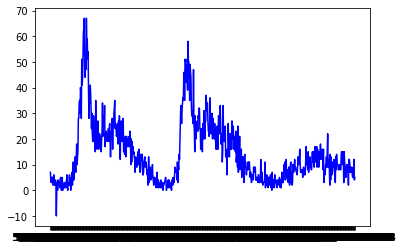

In [7]:
plt.plot(time_valid, x_valid, color = 'blue')
plt.plot(time_valid, results, color = 'green')

In [ ]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(new_model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
time_valid = [i for i in range(len(time_valid))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_valid, x_valid, color = 'blue')
plt.plot(time_valid, results, color = 'green')
plt.ylim(top=120)
# plot_series(time_valid, x_valid)
# plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

In [ ]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (x_valid - results)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

## Forecast on Typical Day Slice

In [ ]:
typical_actuals = x_valid[:480]
typical_predictions = results[:480]
#print (typical_predictions)
mae = tf.keras.metrics.mean_absolute_error(typical_actuals, typical_predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(typical_actuals, typical_predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(typical_actuals, typical_predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (typical_actuals - typical_predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

In [ ]:
time_typical = [i for i in range(len(typical_actuals))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_typical, typical_actuals, color = 'blue')
plt.plot(time_typical, typical_predictions, color = 'green')
plt.ylim(top=120)

## Forecast on Atypical Day Slice

In [ ]:
atypical_actuals = x_valid[-240:]
atypical_predictions = results[-240:]
#print (atypical_predictions)

mae = tf.keras.metrics.mean_absolute_error(atypical_actuals, atypical_predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(atypical_actuals, atypical_predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(atypical_actuals, atypical_predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (atypical_actuals - atypical_predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

In [ ]:
time_atypical = [i for i in range(len(atypical_actuals))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_atypical, atypical_actuals, color = 'blue')
plt.plot(time_atypical, atypical_predictions, color = 'green')
plt.ylim(top=120)

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [ ]:
forecast = []
results = []

slice_val_time = 230
sliced_val_series = x_valid[:slice_val_time] 

#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
units_missing = 30
for t in range(units_missing):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    sliced_val_series = np.append(sliced_val_series, forecast[-1])


#forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
# print (results)
print (sliced_val_series)

sliced_val_actual = x_valid[:slice_val_time+units_missing] 
sliced_val_times = time_valid[:slice_val_time+units_missing]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual, color = 'blue')
plt.plot(sliced_val_times, sliced_val_series, color = 'green')
plt.ylim(top=120)

# plot_series(sliced_val_times, sliced_val_actual)
# plot_series(sliced_val_times, sliced_val_series)

In [ ]:
tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()

In [ ]:
mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (sliced_val_actual-sliced_val_series)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

In [ ]:
actuals_slice = sliced_val_actual[-30:]
predictions_slice = sliced_val_series[-30:]
mae = tf.keras.metrics.mean_absolute_error(actuals_slice, predictions_slice).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals_slice, predictions_slice).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals_slice, predictions_slice).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals_slice - predictions_slice)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

## Code for Different Time Slice

In [ ]:
mae_array = []
rmse_array = []
std_array = []
for slice_val_time in range(100,351,10):
    forecast = []
    results = []

    #slice_val_time = 480
    sliced_val_series = x_valid[:slice_val_time] 

    #forecasts only on validation part of time series
    #series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
    units_missing = 120
    for t in range(units_missing):
        l=len(sliced_val_series)
        #print (sliced_val_series[(l-window_size):l])
        forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
        sliced_val_series = np.append(sliced_val_series, forecast[-1])


    #forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    # print (results)
    # print (sliced_val_series)

    sliced_val_actual = x_valid[:slice_val_time+units_missing] 
    sliced_val_times = time_valid[:slice_val_time+units_missing]

    sliced_val_times = [i for i in range(len(sliced_val_times))]
    
    actuals = sliced_val_actual[-units_missing:]
    predictions = sliced_val_series[-units_missing:]
    
    mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
    print ("mean absolute error: "+ str(mae))
    mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
    print ("mean squared error: "+ str(mse))
    rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
    print ("root mean squared error: "+ str(rmse))
    array_of_errors = (actuals - predictions)
    forecast_bias = sum(array_of_errors)
    #print (array_of_errors)
    print ("forecast_bias: "+ str(forecast_bias))
    std_dev_errors = np.std(array_of_errors)
    print ("standard dev of errors: "+ str(std_dev_errors))
    
    mae_array.append(mae)
    rmse_array.append(rmse)
    std_array.append(std_dev_errors)

In [ ]:
print (mae_array)
print (rmse_array)
print (std_array)

## Moving Average

In [ ]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

In [ ]:
moving_avg = moving_average_forecast(series, window_size)[split_time - window_size:]

# plt.figure(figsize=(10, 6))
# plot_series(time_valid, x_valid)
# plot_series(time_valid, moving_avg)
time_valid = [i for i in range(len(time_valid))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(time_valid, x_valid, color = 'blue')
plt.plot(time_valid, moving_avg, color = 'green')
plt.ylim(top=120)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

In [ ]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (x_valid - moving_avg)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

In [ ]:
forecast = []
results = []

slice_val_time = 480
sliced_val_series = x_valid[:slice_val_time] 

print (len(sliced_val_series))
# x_val = series[split_time-window_size:]
#sliced_val_series =x_valid

#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
units_missing = 240
for t in range(units_missing):
    #forecast.append(series[time:time + window_size].mean())
    #print (t)
    forecast.append(sliced_val_series[t:t + window_size].mean())
    sliced_val_series = np.append(sliced_val_series, forecast[-1])
#     l=len(sliced_val_series)
#     print (l)
#     forecast.append(moving_average_forecast(sliced_val_series, window_size))
#     #print (sliced_val_series[(l-window_size):l])
#     #forecast.append(model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
#     sliced_val_series = np.append(sliced_val_series, forecast[-1])

#print (forecast)
# #forecast = forecast[split_time-window_size:]
# #results = np.array(forecast)[:, 0, 0]
# # print (results)
#print (sliced_val_series)
# plt.figure(figsize=(10, 6))
# plt.xticks(rotation=90)

sliced_val_actual = x_valid[:slice_val_time+units_missing] 
sliced_val_times = time_valid[:slice_val_time+units_missing]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual, color = 'blue')
plt.plot(sliced_val_times, sliced_val_series, color = 'green')
plt.ylim(top=120)

# plot_series(sliced_val_times, sliced_val_actual)
# plot_series(sliced_val_times, sliced_val_series)

In [ ]:
tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()

In [ ]:
mae = tf.keras.metrics.mean_absolute_error(sliced_val_actual, sliced_val_series).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(sliced_val_actual, sliced_val_series).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (sliced_val_actual - sliced_val_series)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

## Model Performance on 18th March for Simulation Experiment

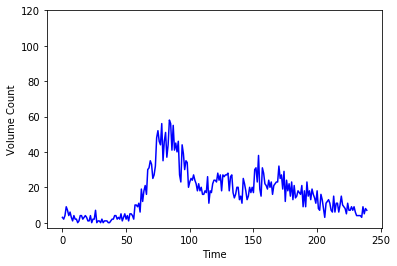

In [9]:
## Load the orginal csv 
dataset_orginal = pd.read_csv('allmonday_reviseddata.csv', header=0, index_col=None)

## Infill nan with -10 
dataset_original_w_missing = dataset_orginal.fillna(-10,inplace=True)
dataset_original = dataset_orginal[:-240]
dataset_original=dataset_original[dataset_original['date_time'].str.contains("3/18/2019")==True]

#extract State-EB-L_1 series for 18th March
series_18march = dataset_original['State-EB-L_2'].values
time_18march = dataset_original['date_time'].values

time_num_18march = [i for i in range(len(series_18march))]

# Plot the 18th March data
plt.plot(time_num_18march, series_18march, color = 'blue')
#plot_series(time_num, series)

plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.ylim(top=120)
plt.grid(False)

(-2.9000000000000004, 120)

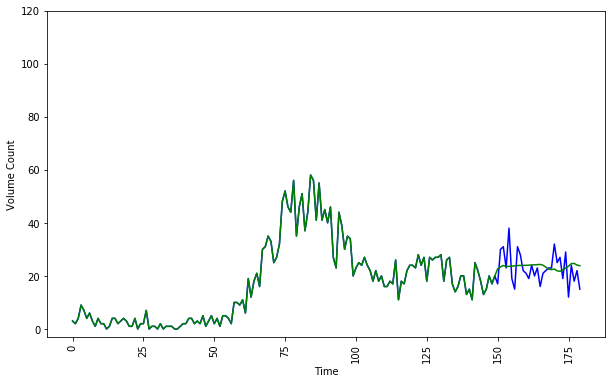

In [10]:
##apply model to the 18th march data
forecast = []
results = []

slice_val_time = 150
sliced_val_series = series_18march[:slice_val_time] 

#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
units_missing = 30
for t in range(units_missing):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    sliced_val_series = np.append(sliced_val_series, forecast[-1])


#forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
# print (results)
# print (sliced_val_series)

sliced_val_actual = series_18march[:slice_val_time+units_missing] 
sliced_val_times = time_18march[:slice_val_time+units_missing]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual, color = 'blue')
plt.plot(sliced_val_times, sliced_val_series, color = 'green')
plt.ylim(top=120)

In [11]:
print (sliced_val_actual)
print (sliced_val_series)
actuals = sliced_val_actual[-units_missing:]
predictions = sliced_val_series [-units_missing:]

mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals-predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

[ 3.  2.  4.  9.  7.  4.  6.  3.  1.  4.  2.  2.  0.  1.  4.  4.  2.  3.
  4.  3.  1.  1.  4.  0.  2.  2.  7.  0.  1.  1.  0.  2.  0.  1.  1.  1.
  0.  0.  1.  2.  2.  4.  4.  2.  3.  2.  5.  1.  3.  5.  2.  4.  1.  5.
  5.  4.  2. 10. 10.  9. 11.  6. 19. 12. 18. 21. 16. 30. 31. 35. 33. 25.
 27. 32. 48. 52. 46. 44. 56. 35. 46. 51. 37. 44. 58. 56. 41. 55. 41. 45.
 40. 46. 27. 23. 44. 39. 30. 35. 34. 20. 23. 25. 24. 27. 24. 22. 18. 22.
 18. 20. 16. 16. 18. 17. 26. 11. 18. 17. 22. 24. 24. 23. 28. 24. 27. 18.
 27. 26. 27. 27. 28. 18. 26. 27. 17. 14. 16. 20. 20. 13. 15. 11. 25. 22.
 18. 13. 15. 20. 17. 20. 17. 30. 31. 23. 38. 19. 15. 31. 28. 22. 21. 19.
 24. 20. 23. 16. 21. 22. 23. 23. 32. 25. 27. 19. 29. 12. 24. 18. 22. 15.]
[ 3.          2.          4.          9.          7.          4.
  6.          3.          1.          4.          2.          2.
  0.          1.          4.          4.          2.          3.
  4.          3.          1.          1.          4.          0.
  2.     

In [ ]:
## Store actual and predicted values in csv
pd.DataFrame(sliced_val_actual).to_csv("actual_state_eb_l2_univariate_18mar.csv")
pd.DataFrame(sliced_val_series).to_csv("predicted_state_eb_l2_univariate_18mar.csv")

## Model Performance on 27 May (Memorial Day) for Simulation Experiment

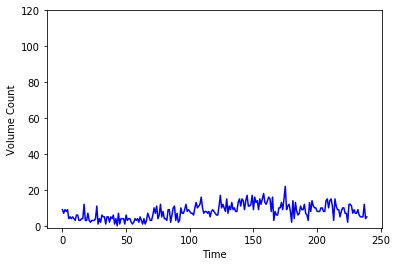

In [12]:
## Load the orginal csv 
dataset_orginal = pd.read_csv('allmonday_reviseddata_modified.csv', header=0, index_col=None)

## Infill nan with -10 
dataset_original_w_missing = dataset_orginal.fillna(-10,inplace=True)
dataset_original = dataset_orginal[:-240]
dataset_original=dataset_original[dataset_original['date_time'].str.contains("5/27/2019")==True]

#extract State-EB-L_1 series for 18th March
series_5may = dataset_original['State-EB-L_2'].values
time_5may = dataset_original['date_time'].values

time_num_5may = [i for i in range(len(series_5may))]

# Plot the 18th March data
plt.plot(time_num_5may, series_5may, color = 'blue')
#plot_series(time_num, series)

plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.ylim(top=120)
plt.grid(False)

(-2.6509719848632813, 120)

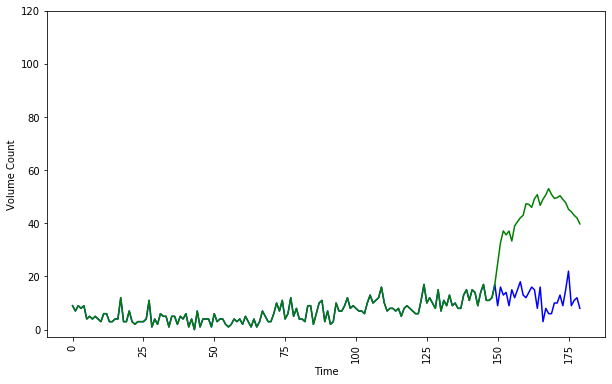

In [13]:
##apply model to the 27th may data
forecast = []
results = []

slice_val_time = 150
sliced_val_series = series_5may[:slice_val_time] 

#forecasts only on validation part of time series
#series_valid would be the validation part of time series starting from where you want to predict and foreact for number of units you want to predict
units_missing = 30
for t in range(units_missing):
    l=len(sliced_val_series)
    #print (sliced_val_series[(l-window_size):l])
    forecast.append(new_model.predict(sliced_val_series[(l-window_size):l][np.newaxis]))
    sliced_val_series = np.append(sliced_val_series, forecast[-1])


#forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
# print (results)
# print (sliced_val_series)

sliced_val_actual = series_5may[:slice_val_time+units_missing] 
sliced_val_times = time_5may[:slice_val_time+units_missing]

sliced_val_times = [i for i in range(len(sliced_val_times))]
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)
plt.xlabel("Time")
plt.ylabel("Volume Count")
plt.grid(False)
plt.plot(sliced_val_times, sliced_val_actual, color = 'blue')
plt.plot(sliced_val_times, sliced_val_series, color = 'green')
plt.ylim(top=120)

In [14]:
print (sliced_val_actual)
print (sliced_val_series)
actuals = sliced_val_actual[-units_missing:]
predictions = sliced_val_series [-units_missing:]

mae = tf.keras.metrics.mean_absolute_error(actuals, predictions).numpy()
print ("mean absolute error: "+ str(mae))
mse = tf.keras.metrics.mean_squared_error(actuals, predictions).numpy()
print ("mean squared error: "+ str(mse))
rmse = math.sqrt(tf.keras.metrics.mean_squared_error(actuals, predictions).numpy())
print ("root mean squared error: "+ str(rmse))
array_of_errors = (actuals-predictions)
forecast_bias = sum(array_of_errors)
#print (array_of_errors)
print ("forecast_bias: "+ str(forecast_bias))
std_dev_errors = np.std(array_of_errors)
print ("standard dev of errors: "+ str(std_dev_errors))

[ 9.  7.  9.  8.  9.  4.  5.  4.  5.  4.  3.  6.  6.  3.  3.  4.  4. 12.
  3.  3.  7.  3.  2.  3.  3.  3.  4. 11.  1.  4.  2.  6.  5.  5.  1.  5.
  5.  2.  5.  4.  6.  1.  4.  0.  7.  1.  4.  4.  4.  1.  6.  3.  4.  4.
  2.  1.  2.  4.  3.  4.  2.  5.  3.  1.  4.  1.  3.  7.  5.  3.  3.  6.
 10.  7. 11.  4.  6. 12.  5.  8.  4.  4.  3.  9.  9.  2.  6. 10. 11.  3.
  7.  2.  3. 10.  7.  7.  9. 12.  8.  9.  8.  7.  7.  6. 10. 13. 10. 11.
 12. 16. 10.  7.  8.  8.  7.  8.  5.  8.  9.  8.  7.  6.  6. 11. 17. 10.
 12. 10.  8. 15.  7. 11.  9. 13.  9. 10.  8.  8. 13. 15. 11. 15. 14.  9.
 14. 17. 11. 11. 12. 17.  9. 16. 13. 14.  9. 15. 12. 15. 18. 13. 12. 14.
 16. 15.  8. 16.  3.  8.  6.  6. 10. 10. 13.  9. 15. 22.  9. 11. 12.  8.]
[ 9.          7.          9.          8.          9.          4.
  5.          4.          5.          4.          3.          6.
  6.          3.          3.          4.          4.         12.
  3.          3.          7.          3.          2.          3.
  3.     

In [ ]:
## Store actual and predicted values in csv
pd.DataFrame(sliced_val_actual).to_csv("actual_state_eb_l2_univariate_27may.csv")
pd.DataFrame(sliced_val_series).to_csv("predicted_state_eb_l2_univariate_27may.csv")